# Initial Model 

In [1]:
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import torch
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError  # Import UnidentifiedImageError


In [9]:


class YelpPhotoDataset(Dataset):
    def __init__(self, photos_folder, image_size=64, max_samples=None):
        self.photos_folder = photos_folder
        self.image_size = image_size
        self.image_files = [f for f in os.listdir(photos_folder) if f.endswith('.jpg')]  # Only jpg images
        if max_samples:
            self.image_files = self.image_files[:max_samples]  # Limit number of samples

    def __getitem__(self, idx):
        img_path = os.path.join(self.photos_folder, self.image_files[idx])
        try:
            image = Image.open(img_path).convert('RGB')  # Open image
            image = image.resize((self.image_size, self.image_size))  # Resize the image
            image = transforms.ToTensor()(image)  # Convert to tensor
            return image
        except (UnidentifiedImageError, IOError) as e:
            # Catch errors related to invalid or unreadable images
            print(f"Error loading image {img_path}: {e}")
            return None  # Return None if there's an error loading the image

    def __len__(self):
        return len(self.image_files)


# Define photos folder path
photos_folder = 'C:/Users/singh/Downloads/yelp_dataset/photos'  # Replace with your correct path

# Custom collate function to filter out None values from batches
def collate_fn(batch):
    batch = [item for item in batch if item is not None]  # Remove None values
    return torch.stack(batch, 0) if len(batch) > 0 else None  # Only stack if there's valid data

# Create Dataset and DataLoader
dataset = YelpPhotoDataset(photos_folder, image_size=64, max_samples=50000)  # Limit to 50000 images for testing
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=0, collate_fn=collate_fn)

# Define the Generator model (as before)
class Generator(nn.Module):
    def __init__(self, latent_dim, img_channels, img_size):
        super(Generator, self).__init__()
        self.init_size = img_size // 4  # Starting size of the image after fully connected layer

        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 128 * self.init_size ** 2)  # Linear layer to convert latent dim to image size
        )
        
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),  # Normalize the data to prevent training instability
            nn.Upsample(scale_factor=2),  # Upsample image
            nn.Conv2d(128, 128, 3, stride=1, padding=1),  # Convolutional layer
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),  # Another upsample
            nn.Conv2d(128, img_channels, 3, stride=1, padding=1),  # Output layer to generate image
            nn.Tanh(),  # Tanh to scale output between -1 and 1 (standard for GANs)
        )

    def forward(self, z):
        out = self.fc(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)  # Reshape after FC layer
        img = self.conv_blocks(out)
        return img

# Define the Critic model (as before)
class Critic(nn.Module):
    def __init__(self, img_channels, img_size):
        super(Critic, self).__init__()

        # Example: img_size = 64 (assuming a 64x64 image)
        # Manually calculate output size after each layer
        conv1_output = (img_size - 3 + 2*1) // 2 + 1  # Kernel size 3, padding 1, stride 2
        conv2_output = (conv1_output - 3 + 2*1) // 2 + 1  # Kernel size 3, padding 1, stride 2
        conv3_output = (conv2_output - 3 + 2*1) // 2 + 1  # Kernel size 3, padding 1, stride 2
        conv4_output = (conv3_output - 3 + 2*1) // 2 + 1  # Kernel size 3, padding 1, stride 2

        # Calculate the flattened size (number of features) after all convolutional layers
        flattened_size = conv4_output * conv4_output * 512  # 512 channels after the last Conv layer

        # Define the convolutional layers
        self.model = nn.Sequential(
            nn.Conv2d(img_channels, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Fully connected layer with correct input size
        self.fc = nn.Linear(flattened_size, 1)

    def forward(self, img):
        x = self.model(img)  # Apply convolutional layers
        x = x.view(x.size(0), -1)  # Flatten the output (batch_size, num_features)
        output = self.fc(x)  # Pass through the fully connected layer
        return output
from PIL import Image, UnidentifiedImageError


Epoch 1/20 start
Epoch 1 finished
Epoch 2/20 start
Epoch 2 finished
Epoch 3/20 start
Epoch 3 finished
Epoch 4/20 start
Epoch 4 finished
Epoch 5/20 start
Epoch 5 finished
Epoch 6/20 start
Epoch 6 finished
Epoch 7/20 start
Epoch 7 finished
Epoch 8/20 start
Epoch 8 finished
Epoch 9/20 start
Epoch 9 finished
Epoch 10/20 start
Epoch 10 finished
Epoch 11/20 start
Epoch 11 finished
Epoch 12/20 start
Epoch 12 finished
Epoch 13/20 start
Epoch 13 finished
Epoch 14/20 start
Epoch 14 finished
Epoch 15/20 start
Epoch 15 finished
Epoch 16/20 start
Epoch 16 finished
Epoch 17/20 start
Epoch 17 finished
Epoch 18/20 start
Epoch 18 finished
Epoch 19/20 start
Epoch 19 finished
Epoch 20/20 start
Epoch 20 finished


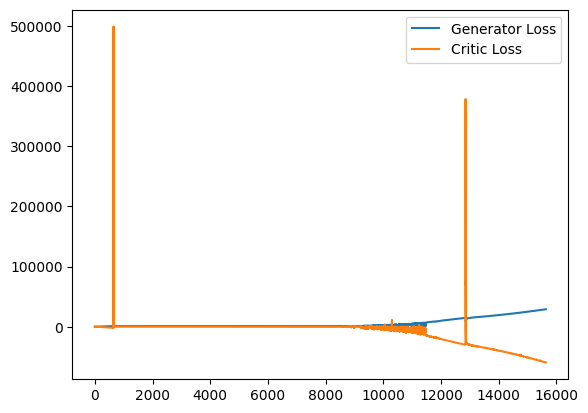

In [ ]:

# Hyperparameters
latent_dim = 100  # Latent vector dimension
img_size = 64  # Size of generated images
img_channels = 3  # Number of image channels (RGB)
epochs = 20  # Number of epochs for training
batch_size = 64  # Batch size for training

lambda_gp = 10  # Gradient penalty weight (used for Wasserstein loss regularization)

# Initialize models and optimizers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator(latent_dim, img_channels, img_size).to(device)
critic = Critic(img_channels, img_size).to(device)

lr = 0.0002  # Learning rate
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))  # Optimizer for Generator
optimizer_C = optim.Adam(critic.parameters(), lr=lr, betas=(0.5, 0.999))  # Optimizer for Critic

# Gradient Penalty Calculation
def compute_gradient_penalty(critic, real_samples, fake_samples):
    alpha = torch.randn((real_samples.size(0), 1, 1, 1), device=real_samples.device)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = critic(interpolates)
    fake = torch.ones(d_interpolates.size(), requires_grad=False, device=real_samples.device)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty
# Safe image loading function
def safe_load_image(image_path):
    try:
        # Try loading the image
        return Image.open(image_path)
    except (UnidentifiedImageError, IOError) as e:
        # Catch errors related to invalid or unreadable images
        print(f"Error loading image {image_path}: {str(e)}")
        return None  # Return None if the image can't be loaded
# Training Loop
gen_losses = []
critic_losses = []

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs} start")
    for i, imgs in enumerate(dataloader):
        if imgs is None:  # Skip batches with no valid images
            continue
        
        batch_size = imgs.size(0)  # Get the current batch size (could be less than the expected batch size)
        imgs = imgs.to(device)  # Move batch to GPU
        
        # Train Critic
        optimizer_C.zero_grad()
        z = torch.randn(batch_size, latent_dim, device=device)  # Generate random latent vector with the same batch size
        fake_imgs = generator(z)  # Generate fake images
        
        critic_real = critic(imgs)  # Real image critic score
        critic_fake = critic(fake_imgs.detach())  # Fake image critic score
        gradient_penalty = compute_gradient_penalty(critic, imgs, fake_imgs)
        critic_loss = critic_fake.mean() - critic_real.mean() + lambda_gp * gradient_penalty
        critic_loss.backward()
        optimizer_C.step()
        
        # Train Generator every 5th step
        if i % 5 == 0:
            optimizer_G.zero_grad()
            fake_imgs = generator(z)  # Generate fake images
            critic_fake = critic(fake_imgs)  # Fake image critic score
            gen_loss = -critic_fake.mean()  # Generator loss (Wasserstein GAN)
            gen_loss.backward()
            optimizer_G.step()
        
        # Track losses for later analysis
        gen_losses.append(gen_loss.item())
        critic_losses.append(critic_loss.item())
        
    print(f"Epoch {epoch + 1} finished")

# Plot the losses
plt.plot(gen_losses, label='Generator Loss')
plt.plot(critic_losses, label='Critic Loss')
plt.legend()
plt.show()
# Save the trained models and optimizers
torch.save({
    'epoch': epoch,
    'generator_state_dict': generator.state_dict(),
    'critic_state_dict': critic.state_dict(),
    'optimizer_G_state_dict': optimizer_G.state_dict(),
    'optimizer_C_state_dict': optimizer_C.state_dict(),
    'losses': (gen_losses, critic_losses)
}, 'wgan_model_v_initial.pth')



# Run 2- Best Model

In [4]:
import torchvision 
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import torch
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt

from PIL import Image, UnidentifiedImageError  # Import UnidentifiedImageError

class YelpPhotoDataset(Dataset):
    def __init__(self, photos_folder, image_size=64, max_samples=None):
        self.photos_folder = photos_folder
        self.image_size = image_size
        self.image_files = [f for f in os.listdir(photos_folder) if f.endswith('.jpg')]  # Only jpg images
        if max_samples:
            self.image_files = self.image_files[:max_samples]  # Limit number of samples

    def __getitem__(self, idx):
        img_path = os.path.join(self.photos_folder, self.image_files[idx])
        try:
            image = Image.open(img_path).convert('RGB')  # Open image
            image = image.resize((self.image_size, self.image_size))  # Resize the image
            image = transforms.ToTensor()(image)  # Convert to tensor
            return image
        except (UnidentifiedImageError, IOError) as e:
            # Catch errors related to invalid or unreadable images
            print(f"Error loading image {img_path}: {e}")
            return None  # Return None if there's an error loading the image

    def __len__(self):
        return len(self.image_files)


# Define photos folder path
photos_folder = 'C:/Users/singh/Downloads/yelp_dataset/photos'  # Replace with your correct path

# Custom collate function to filter out None values from batches
def collate_fn(batch):
    batch = [item for item in batch if item is not None]  # Remove None values
    return torch.stack(batch, 0) if len(batch) > 0 else None  # Only stack if there's valid data


# Create Dataset and DataLoader
dataset = YelpPhotoDataset(photos_folder, image_size=64, max_samples=500)  # Limit to 2000 images for testing
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=0, collate_fn=collate_fn)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.init_size = 64 // 4  # Output size after upscaling
        self.fc = nn.Sequential(
            nn.Linear(256, 128 * self.init_size ** 2),  # Adjust for latent_dim
            nn.BatchNorm1d(128 * self.init_size ** 2),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.conv_blocks = nn.Sequential(
            nn.Upsample(scale_factor=2),  # 16x16 -> 32x32
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),  # 32x32 -> 64x64
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 3, 3, stride=1, padding=1),
            nn.Tanh(),  # Output values in range [-1, 1]
        )

    def forward(self, z):
        out = self.fc(z)
        out = out.view(out.size(0), 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

# Define the Critic model
class Critic(nn.Module):
    def __init__(self, img_channels, img_size):
        super(Critic, self).__init__()

        # Example: img_size = 64 (assuming a 64x64 image)
        # Manually calculate output size after each layer
        conv1_output = (img_size - 3 + 2*1) // 2 + 1  # Kernel size 3, padding 1, stride 2
        conv2_output = (conv1_output - 3 + 2*1) // 2 + 1  # Kernel size 3, padding 1, stride 2
        conv3_output = (conv2_output - 3 + 2*1) // 2 + 1  # Kernel size 3, padding 1, stride 2
        conv4_output = (conv3_output - 3 + 2*1) // 2 + 1  # Kernel size 3, padding 1, stride 2

        # Calculate the flattened size (number of features) after all convolutional layers
        flattened_size = conv4_output * conv4_output * 512  # 512 channels after the last Conv layer

        # Define the convolutional layers
        self.model = nn.Sequential(
            nn.Conv2d(img_channels, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Fully connected layer with correct input size
        self.fc = nn.Linear(flattened_size, 1)

    def forward(self, img):
        x = self.model(img)  # Apply convolutional layers
        x = x.view(x.size(0), -1)  # Flatten the output (batch_size, num_features)
        output = self.fc(x)  # Pass through the fully connected layer
        return output


In [13]:

# Hyperparameters
latent_dim = 256  # Latent vector dimension
img_size = 64  # Size of generated images
img_channels = 3  # Number of image channels (RGB)
epochs = 10  # Number of epochs for training
batch_size = 64  # Batch size for training


# Experiment Done

Epoch 1/10 start
Batch 1/782, Critic Loss: -0.1545, Generator Loss: 0.7623
Batch 2/782, Critic Loss: -1.2868, Generator Loss: 0.5026
Batch 3/782, Critic Loss: -2.4178, Generator Loss: 0.4462
Batch 4/782, Critic Loss: -3.1526, Generator Loss: 0.3766
Batch 5/782, Critic Loss: -4.3697, Generator Loss: 0.3498
Batch 6/782, Critic Loss: -5.5110, Generator Loss: 0.8076
Batch 7/782, Critic Loss: -6.2281, Generator Loss: 1.6307
Batch 8/782, Critic Loss: -8.1086, Generator Loss: 3.2932
Batch 9/782, Critic Loss: -10.2837, Generator Loss: 4.9312
Batch 10/782, Critic Loss: -10.3419, Generator Loss: 5.7903
Batch 11/782, Critic Loss: -12.2166, Generator Loss: 8.2402
Batch 12/782, Critic Loss: -13.8045, Generator Loss: 8.7484
Batch 13/782, Critic Loss: -17.3800, Generator Loss: 11.1429
Batch 14/782, Critic Loss: -20.6543, Generator Loss: 13.9762
Batch 15/782, Critic Loss: -22.7188, Generator Loss: 12.3415
Batch 16/782, Critic Loss: -24.1415, Generator Loss: 16.7590
Batch 17/782, Critic Loss: -28.5478,

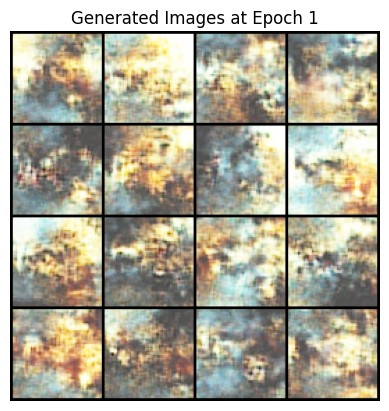

Epoch 2/10 start
Batch 1/782, Critic Loss: 856.2699, Generator Loss: 371.7342
Batch 2/782, Critic Loss: 678.8665, Generator Loss: 354.6173
Batch 3/782, Critic Loss: 634.7745, Generator Loss: 335.0392
Batch 4/782, Critic Loss: 393.9493, Generator Loss: 326.3464
Batch 5/782, Critic Loss: 892.2678, Generator Loss: 310.8895
Batch 6/782, Critic Loss: 361.9343, Generator Loss: 309.8482
Batch 7/782, Critic Loss: 476.8417, Generator Loss: 317.1620
Batch 8/782, Critic Loss: 567.8340, Generator Loss: 288.5782
Batch 9/782, Critic Loss: 418.9858, Generator Loss: 311.5741
Batch 10/782, Critic Loss: 190.9125, Generator Loss: 308.2197
Batch 11/782, Critic Loss: 214.6934, Generator Loss: 296.1552
Batch 12/782, Critic Loss: 210.7397, Generator Loss: 284.1454
Batch 13/782, Critic Loss: 152.5405, Generator Loss: 291.8964
Batch 14/782, Critic Loss: 427.1361, Generator Loss: 262.2784
Batch 15/782, Critic Loss: 214.1109, Generator Loss: 275.6182
Batch 16/782, Critic Loss: 188.3472, Generator Loss: 275.1928


In [ ]:

lambda_gp = 3  # Gradient penalty weight (used for Wasserstein loss regularization)

# Initialize models and optimizers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator(latent_dim, img_channels, img_size).to(device)
critic = Critic(img_channels, img_size).to(device)

lr = 0.0001  # Learning rate
lr2= 0.0002  # Learning rate
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))  # Optimizer for Generator
optimizer_C = optim.Adam(critic.parameters(), lr=lr2, betas=(0.5, 0.999))  # Optimizer for Critic

# Gradient Penalty Calculation
def compute_gradient_penalty(critic, real_samples, fake_samples):
    alpha = torch.randn((real_samples.size(0), 1, 1, 1), device=real_samples.device)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = critic(interpolates)
    fake = torch.ones(d_interpolates.size(), requires_grad=False, device=real_samples.device)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

# Training Loop
gen_losses = []
critic_losses = []

# Save generated images
def save_generated_images(epoch, fixed_z):
    with torch.no_grad():
        gen_imgs = generator(fixed_z).cpu()
        gen_imgs = gen_imgs * 0.5 + 0.5  # Rescale images to [0,1]
        grid = torchvision.utils.make_grid(gen_imgs, nrow=4, normalize=True)
        plt.imshow(grid.permute(1, 2, 0))
        plt.title(f"Generated Images at Epoch {epoch+1}")
        plt.axis('off')
        plt.show()

# Random vector to visualize the output throughout training
fixed_z = torch.randn(16, latent_dim, device=device)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs} start")
    for i, imgs in enumerate(dataloader):
        if imgs is None:  # Skip batches with no valid images
            continue
        
        batch_size = imgs.size(0)  # Get the current batch size (could be less than the expected batch size)
        imgs = imgs.to(device)  # Move batch to GPU
        
        # Train Critic
        optimizer_C.zero_grad()
        z = torch.randn(batch_size, latent_dim, device=device)  # Generate random latent vector with the same batch size
        fake_imgs = generator(z)  # Generate fake images
        
        critic_real = critic(imgs)  # Real image critic score
        critic_fake = critic(fake_imgs.detach())  # Fake image critic score
        gradient_penalty = compute_gradient_penalty(critic, imgs, fake_imgs)
        critic_loss = critic_fake.mean() - critic_real.mean() + lambda_gp * gradient_penalty
        critic_loss.backward()
        optimizer_C.step()
        
        # Train Generator every 5th step
        if i % 1 == 0:
            optimizer_G.zero_grad()
            fake_imgs = generator(z)  # Generate fake images
            critic_fake = critic(fake_imgs)  # Fake image critic score
            gen_loss = -critic_fake.mean()  # Generator loss (Wasserstein GAN)
            gen_loss.backward()
            optimizer_G.step()

        print(f"Batch {i + 1}/{len(dataloader)}, Critic Loss: {critic_loss.item():.4f}, Generator Loss: {gen_loss.item():.4f}")

        # Track losses for later analysis
        gen_losses.append(gen_loss.item())
        critic_losses.append(critic_loss.item())
        
    # Save images periodically or at the end
    save_generated_images(epoch, fixed_z)

# Plot the losses
plt.plot(gen_losses, label='Generator Loss')
plt.plot(critic_losses, label='Critic Loss')
plt.legend()
plt.show()


In [ ]:
# #Save the trained models and optimizers
# torch.save({
#     'epoch': epoch,
#     'generator_state_dict': generator.state_dict(),
#     'critic_state_dict': critic.state_dict(),
#     'optimizer_G_state_dict': optimizer_G.state_dict(),
#     'optimizer_C_state_dict': optimizer_C.state_dict(),
#     'losses': (gen_losses, critic_losses)
# }, 'wgan_model_v1.pth')


# Run 3- tweaking Hyperparameters

Epoch 1/50, Generator Loss: 2.3730, Critic Loss: -0.9650
Epoch 2/50, Generator Loss: 7.8645, Critic Loss: -2.3808
Epoch 3/50, Generator Loss: 12.0656, Critic Loss: -3.0683
Epoch 4/50, Generator Loss: 14.4751, Critic Loss: -3.1965
Epoch 5/50, Generator Loss: 14.0372, Critic Loss: -2.7873


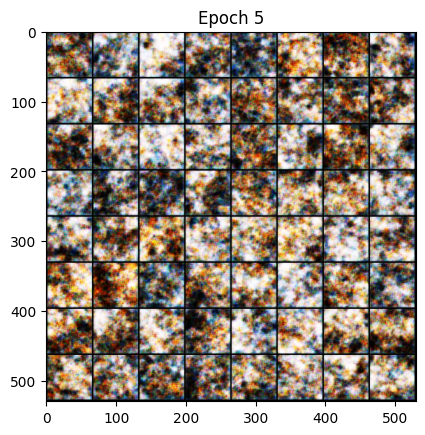

Epoch 6/50, Generator Loss: 14.6773, Critic Loss: -2.4423
Epoch 7/50, Generator Loss: 14.9844, Critic Loss: -2.1306
Epoch 8/50, Generator Loss: 15.5392, Critic Loss: -2.0386
Epoch 9/50, Generator Loss: 16.0537, Critic Loss: -1.9384
Epoch 10/50, Generator Loss: 16.7419, Critic Loss: -2.0184


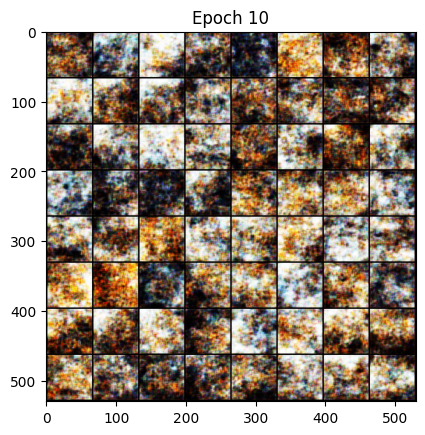

Epoch 11/50, Generator Loss: 16.9340, Critic Loss: -2.0112
Epoch 12/50, Generator Loss: 17.3269, Critic Loss: -2.1489
Epoch 13/50, Generator Loss: 18.6065, Critic Loss: -2.2205
Epoch 14/50, Generator Loss: 19.6218, Critic Loss: -2.3423
Epoch 15/50, Generator Loss: 20.7808, Critic Loss: -2.5029


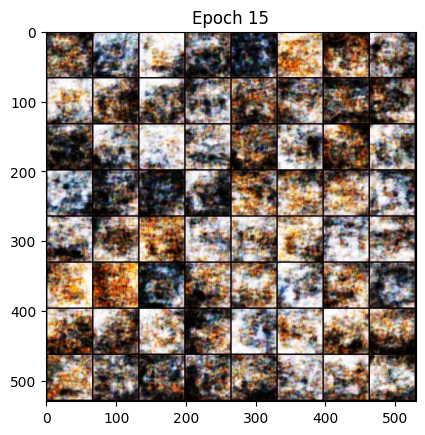

Epoch 16/50, Generator Loss: 23.0341, Critic Loss: -2.6771
Epoch 17/50, Generator Loss: 23.0146, Critic Loss: -2.8668
Epoch 18/50, Generator Loss: 23.9506, Critic Loss: -3.1115
Epoch 19/50, Generator Loss: 26.9381, Critic Loss: -3.2525
Epoch 20/50, Generator Loss: 26.0156, Critic Loss: -4.1315


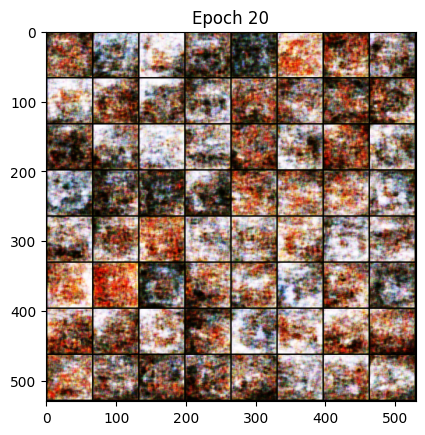

Epoch 21/50, Generator Loss: 31.1257, Critic Loss: -4.2084
Epoch 22/50, Generator Loss: 30.2834, Critic Loss: -4.1655
Epoch 23/50, Generator Loss: 30.7280, Critic Loss: -6.6870
Epoch 24/50, Generator Loss: 34.9864, Critic Loss: -6.6176
Epoch 25/50, Generator Loss: 42.8218, Critic Loss: -3.6193


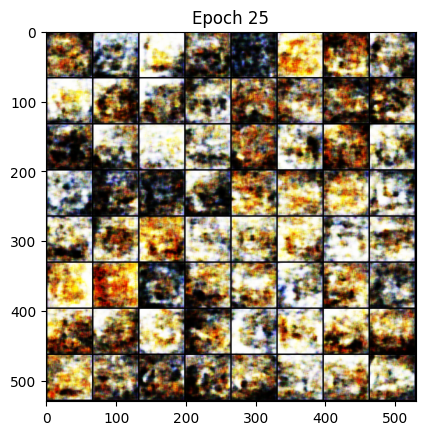

Epoch 26/50, Generator Loss: 40.1287, Critic Loss: -5.0402
Epoch 27/50, Generator Loss: 33.8272, Critic Loss: -7.2213
Epoch 28/50, Generator Loss: 41.7677, Critic Loss: -5.2815
Epoch 29/50, Generator Loss: 42.6741, Critic Loss: -6.8326
Epoch 30/50, Generator Loss: 34.0511, Critic Loss: -7.2387


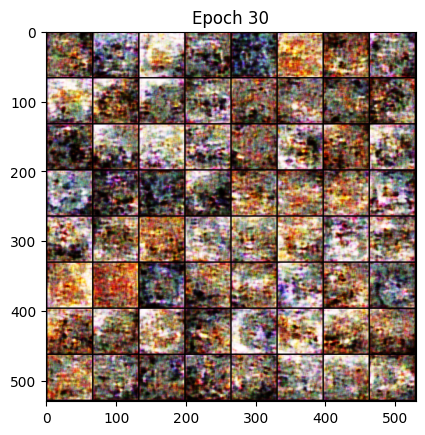

Epoch 31/50, Generator Loss: 42.2084, Critic Loss: -7.3899
Epoch 32/50, Generator Loss: 40.7720, Critic Loss: -8.7190
Epoch 33/50, Generator Loss: 53.3561, Critic Loss: -7.2225
Epoch 34/50, Generator Loss: 39.5810, Critic Loss: -9.5139
Epoch 35/50, Generator Loss: 56.6725, Critic Loss: -9.1716


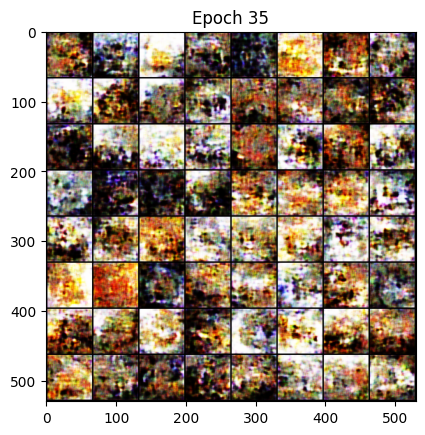

Epoch 36/50, Generator Loss: 49.7310, Critic Loss: -9.5680
Epoch 37/50, Generator Loss: 52.6459, Critic Loss: -10.8099
Epoch 38/50, Generator Loss: 43.2757, Critic Loss: -8.0612
Epoch 39/50, Generator Loss: 57.3956, Critic Loss: -9.0267
Epoch 40/50, Generator Loss: 38.7826, Critic Loss: -11.5679


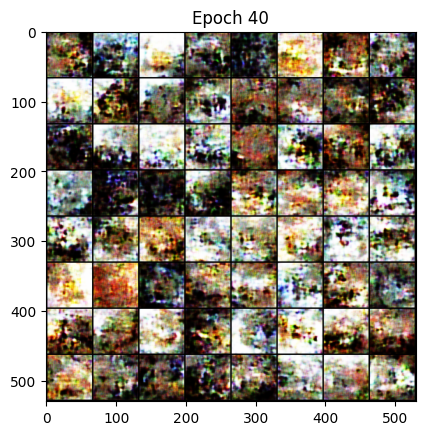

Epoch 41/50, Generator Loss: 51.8668, Critic Loss: -13.7262
Epoch 42/50, Generator Loss: 43.1025, Critic Loss: -14.5222
Epoch 43/50, Generator Loss: 87.4350, Critic Loss: -13.0810
Epoch 44/50, Generator Loss: 45.7952, Critic Loss: -12.0845
Epoch 45/50, Generator Loss: 56.5593, Critic Loss: -14.8169


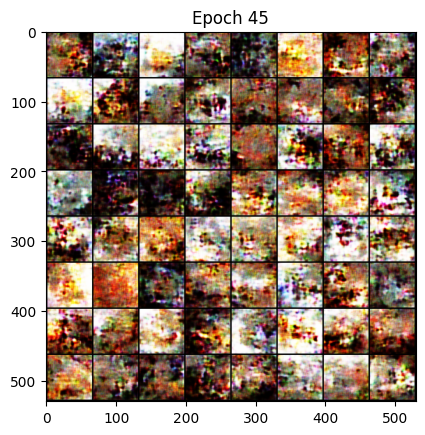

Epoch 46/50, Generator Loss: 72.0075, Critic Loss: -13.9658
Epoch 47/50, Generator Loss: 82.3304, Critic Loss: -17.7199
Epoch 48/50, Generator Loss: 63.0161, Critic Loss: -15.7251
Epoch 49/50, Generator Loss: 74.8112, Critic Loss: -17.1095
Epoch 50/50, Generator Loss: 61.5221, Critic Loss: -19.1575


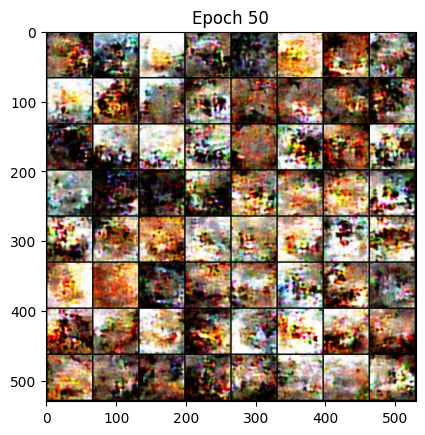

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from PIL import Image, UnidentifiedImageError
import os
import matplotlib.pyplot as plt
import time
from torchvision import transforms


# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Custom Dataset for Yelp Photos
class YelpPhotoDataset(Dataset):
    def __init__(self, photos_folder, transform=None, max_samples=None):
        self.photos_folder = photos_folder
        self.transform = transform
        self.image_files = [f for f in os.listdir(photos_folder) if f.endswith('.jpg')]  # Only jpg images
        if max_samples:
            self.image_files = self.image_files[:max_samples]  # Limit number of samples

    def __getitem__(self, idx):
        img_path = os.path.join(self.photos_folder, self.image_files[idx])
        try:
            image = Image.open(img_path).convert('RGB')  # Open image
            if self.transform:
                image = self.transform(image)  # Apply the transformation pipeline
            return image
        except (UnidentifiedImageError, IOError) as e:
            # Catch errors related to invalid or unreadable images
            print(f"Error loading image {img_path}: {e}")
            return None  # Return None if there's an error loading the image

    def __len__(self):
        return len(self.image_files)


# Custom collate function to filter out None values from batches
def collate_fn(batch):
    batch = [item for item in batch if item is not None]  # Remove None values
    return torch.stack(batch, 0) if len(batch) > 0 else None  # Only stack if there's valid data


class Generator(nn.Module):
    def __init__(self, latent_dim=128):
        super(Generator, self).__init__()
        self.init_size = 64 // 4  # Output size after upscaling
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 128 * self.init_size ** 2),  # Input size now matches latent_dim
            nn.BatchNorm1d(128 * self.init_size ** 2),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.conv_blocks = nn.Sequential(
            nn.Upsample(scale_factor=2),  # 16x16 -> 32x32
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),  # 32x32 -> 64x64
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 3, 3, stride=1, padding=1),
            nn.Tanh(),  # Output values in range [-1, 1]
        )

    def forward(self, z):
        out = self.fc(z)
        out = out.view(out.size(0), 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img



# Define Critic Model
class Critic(nn.Module):
    def __init__(self, img_channels, img_size):
        super(Critic, self).__init__()

        conv1_output = (img_size - 3 + 2*1) // 2 + 1
        conv2_output = (conv1_output - 3 + 2*1) // 2 + 1
        conv3_output = (conv2_output - 3 + 2*1) // 2 + 1
        conv4_output = (conv3_output - 3 + 2*1) // 2 + 1

        flattened_size = conv4_output * conv4_output * 512  # 512 channels after the last Conv layer

        self.model = nn.Sequential(
            nn.Conv2d(img_channels, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.fc = nn.Linear(flattened_size, 1)

    def forward(self, img):
        x = self.model(img)
        x = x.view(x.size(0), -1)
        output = self.fc(x)
        return output


# Gradient Penalty Calculation for WGAN-GP
def compute_gradient_penalty(critic, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=real_samples.device)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = critic(interpolates)
    fake = torch.ones(d_interpolates.size(), device=real_samples.device)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty


# Save generated images for visualization
def save_generated_images(epoch, fixed_z, display=False):
    generator.eval()
    with torch.no_grad():
        samples = generator(fixed_z).cpu()
        grid = torchvision.utils.make_grid(samples, normalize=True, scale_each=True)
        if display:
            # Display image
            plt.imshow(grid.permute(1, 2, 0))
            plt.title(f"Epoch {epoch + 1}")
            plt.show()
        else:
            # Save image
            plt.imshow(grid.permute(1, 2, 0))
            plt.title(f"Epoch {epoch + 1}")
            plt.savefig(f"generated_images_epoch_{epoch + 1}.png")
            plt.close()
    generator.train()


# Hyperparameters
latent_dim = 128
img_size = 64
img_channels = 3
epochs = 50
batch_size = 64
critic_iters = 5
lambda_gp = 10
lr = 0.00005

# Image Transformation
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Initialize models
generator = Generator().to(device)
critic = Critic(img_channels=img_channels, img_size=img_size).to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.0001, betas=(0, 0.9))
optimizer_C = optim.Adam(critic.parameters(), lr=0.00005, betas=(0, 0.9))

# Dataset and DataLoader
photos_folder = 'C:/Users/singh/Downloads/yelp_dataset/photos'  # Update with correct path
dataset = YelpPhotoDataset(photos_folder, transform=transform, max_samples=500)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)

# Fixed noise for consistent image generation
fixed_z = torch.randn(64, latent_dim, device=device)

# Loss tracking
gen_losses = []
critic_losses = []

# Training loop
for epoch in range(epochs):
    epoch_gen_loss = 0
    epoch_critic_loss = 0
    for i, imgs in enumerate(dataloader):
        if imgs is None:
            continue
        
        batch_size = imgs.size(0)
        imgs = imgs.to(device)
        
        # Train Critic
        for _ in range(critic_iters):
            optimizer_C.zero_grad()
            z = torch.randn(batch_size, latent_dim, device=device)
            fake_imgs = generator(z)
            
            critic_real = critic(imgs)
            critic_fake = critic(fake_imgs.detach())
            gradient_penalty = compute_gradient_penalty(critic, imgs, fake_imgs)
            critic_loss = critic_fake.mean() - critic_real.mean() + lambda_gp * gradient_penalty
            critic_loss.backward()
            torch.nn.utils.clip_grad_norm_(critic.parameters(), max_norm=10)
            optimizer_C.step()
        
        epoch_critic_loss += critic_loss.item()
        
        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(batch_size, latent_dim, device=device)
        fake_imgs = generator(z)
        critic_fake = critic(fake_imgs)
        gen_loss = -critic_fake.mean()
        gen_loss.backward()
        optimizer_G.step()
        
        epoch_gen_loss += gen_loss.item()

    # Log per-epoch losses
    avg_gen_loss = epoch_gen_loss / len(dataloader)
    avg_critic_loss = epoch_critic_loss / (len(dataloader) * critic_iters)
    gen_losses.append(avg_gen_loss)
    critic_losses.append(avg_critic_loss)

    print(f"Epoch {epoch + 1}/{epochs}, Generator Loss: {avg_gen_loss:.4f}, Critic Loss: {avg_critic_loss:.4f}")
    
    # Save and display generated images every 5 epochs
    if (epoch + 1) % 5 == 0:
        save_generated_images(epoch, fixed_z, display=True)

# Save the trained models and optimizers


Epoch [1/50], Gen Loss: 5.9494, Critic Loss: -31.1289
Inception Score (IS): 1.2216
Epoch [2/50], Gen Loss: 12.9663, Critic Loss: -57.8951
Inception Score (IS): 1.4389
Epoch [3/50], Gen Loss: 18.9601, Critic Loss: -65.5024
Inception Score (IS): 1.5236
Epoch [4/50], Gen Loss: 23.4282, Critic Loss: -67.8468
Inception Score (IS): 1.5484
Epoch [5/50], Gen Loss: 25.9279, Critic Loss: -68.0163
Inception Score (IS): 1.5302
Epoch [6/50], Gen Loss: 27.6564, Critic Loss: -67.7891
Inception Score (IS): 1.4629
Epoch [7/50], Gen Loss: 30.7475, Critic Loss: -73.3178
Inception Score (IS): 1.5677
Epoch [8/50], Gen Loss: 33.7682, Critic Loss: -77.9924
Inception Score (IS): 1.5944
Epoch [9/50], Gen Loss: 35.9436, Critic Loss: -83.7564
Inception Score (IS): 1.5451
Epoch [10/50], Gen Loss: 40.0999, Critic Loss: -135.7329


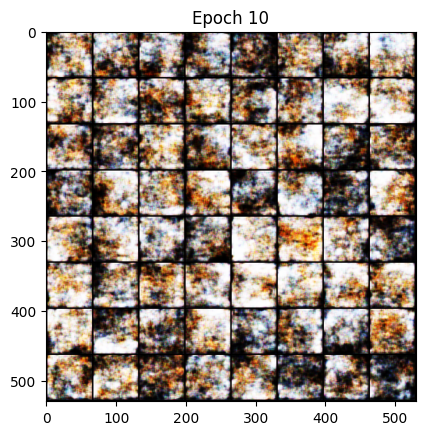

Inception Score (IS): 1.5030
Epoch [11/50], Gen Loss: 47.4654, Critic Loss: -88.9374
Inception Score (IS): 1.4210
Epoch [12/50], Gen Loss: 47.8825, Critic Loss: -104.5066
Inception Score (IS): 1.5342
Epoch [13/50], Gen Loss: 45.3538, Critic Loss: -211.8452
Inception Score (IS): 1.5846
Epoch [14/50], Gen Loss: 58.5691, Critic Loss: -147.8329
Inception Score (IS): 1.3619
Epoch [15/50], Gen Loss: 66.6958, Critic Loss: -121.1654
Inception Score (IS): 1.3893
Epoch [16/50], Gen Loss: 54.1524, Critic Loss: -253.2270
Inception Score (IS): 1.5999
Epoch [17/50], Gen Loss: 61.5096, Critic Loss: -233.0470
Inception Score (IS): 1.4946
Epoch [18/50], Gen Loss: 90.1001, Critic Loss: -93.8621
Inception Score (IS): 1.3899
Epoch [19/50], Gen Loss: 88.3304, Critic Loss: -164.4743
Inception Score (IS): 1.4446
Epoch [20/50], Gen Loss: 64.2697, Critic Loss: -247.3827


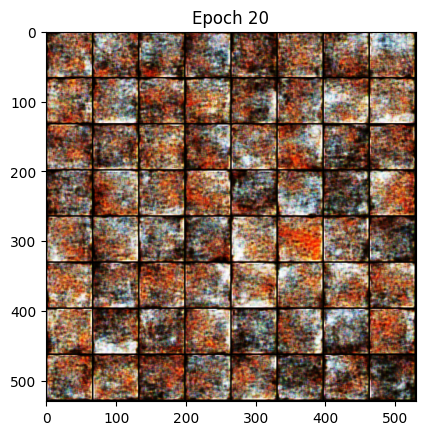

Inception Score (IS): 1.6336
Epoch [21/50], Gen Loss: 73.3023, Critic Loss: -443.1093
Inception Score (IS): 1.5813
Epoch [22/50], Gen Loss: 82.4426, Critic Loss: -70.8524
Inception Score (IS): 1.4700
Epoch [23/50], Gen Loss: 119.0387, Critic Loss: -194.6549
Inception Score (IS): 1.3512
Epoch [24/50], Gen Loss: 82.9217, Critic Loss: -310.2445
Inception Score (IS): 1.6677
Epoch [25/50], Gen Loss: 82.4137, Critic Loss: -531.0269
Inception Score (IS): 1.6429
Epoch [26/50], Gen Loss: 106.8668, Critic Loss: -218.5645
Inception Score (IS): 1.5263
Epoch [27/50], Gen Loss: 128.6771, Critic Loss: -170.2807
Inception Score (IS): 1.4307
Epoch [28/50], Gen Loss: 131.3460, Critic Loss: -246.9075
Inception Score (IS): 1.4275
Epoch [29/50], Gen Loss: 131.6768, Critic Loss: -279.5075
Inception Score (IS): 1.4446
Epoch [30/50], Gen Loss: 139.7991, Critic Loss: -301.6005


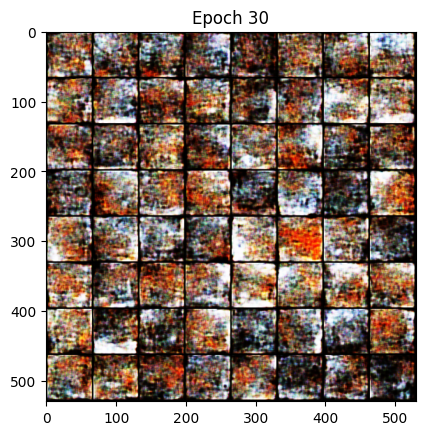

Inception Score (IS): 1.5047
Epoch [31/50], Gen Loss: 72.3712, Critic Loss: -357.7679
Inception Score (IS): 1.4236
Epoch [32/50], Gen Loss: 101.2127, Critic Loss: -421.3685
Inception Score (IS): 1.6563
Epoch [33/50], Gen Loss: 94.3559, Critic Loss: -718.5463
Inception Score (IS): 1.7045
Epoch [34/50], Gen Loss: 121.3799, Critic Loss: -710.0978
Inception Score (IS): 1.5642
Epoch [35/50], Gen Loss: 161.4181, Critic Loss: -248.4785
Inception Score (IS): 1.3266
Epoch [36/50], Gen Loss: 189.5891, Critic Loss: -300.0434
Inception Score (IS): 1.3658
Epoch [37/50], Gen Loss: 135.2936, Critic Loss: -545.2798
Inception Score (IS): 1.4735
Epoch [38/50], Gen Loss: 123.8905, Critic Loss: -922.7663
Inception Score (IS): 1.5369
Epoch [39/50], Gen Loss: 146.5873, Critic Loss: -918.9191
Inception Score (IS): 1.3342
Epoch [40/50], Gen Loss: 206.1419, Critic Loss: -161.3649


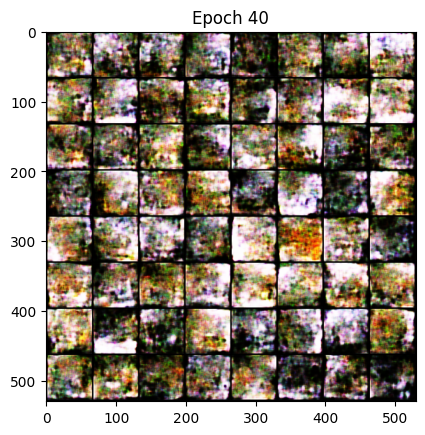

Inception Score (IS): 1.2493
Epoch [41/50], Gen Loss: 212.9338, Critic Loss: -338.5400
Inception Score (IS): 1.3709
Epoch [42/50], Gen Loss: 213.5463, Critic Loss: -257.4294
Inception Score (IS): 1.3557
Epoch [43/50], Gen Loss: 147.3584, Critic Loss: -453.7014
Inception Score (IS): 1.7200
Epoch [44/50], Gen Loss: 132.6471, Critic Loss: -961.8471
Inception Score (IS): 1.8039
Epoch [45/50], Gen Loss: 167.5856, Critic Loss: -1217.4062
Inception Score (IS): 1.6867
Epoch [46/50], Gen Loss: 200.7677, Critic Loss: -745.4336
Inception Score (IS): 1.3426
Epoch [47/50], Gen Loss: 263.4852, Critic Loss: -314.1031
Inception Score (IS): 1.3491
Epoch [48/50], Gen Loss: 220.4469, Critic Loss: -418.8322
Inception Score (IS): 1.3633
Epoch [49/50], Gen Loss: 187.3271, Critic Loss: -251.9864
Inception Score (IS): 1.3032
Epoch [50/50], Gen Loss: 241.4441, Critic Loss: -479.6991


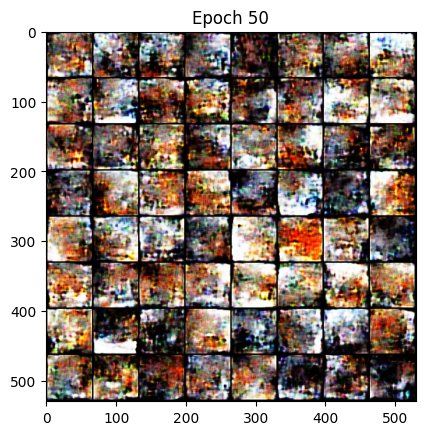

Inception Score (IS): 1.3757


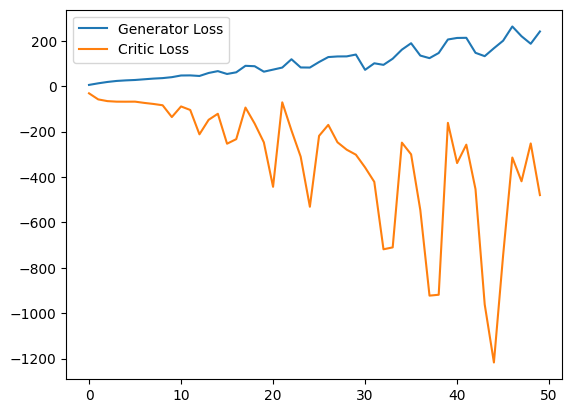

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from PIL import Image, UnidentifiedImageError
import os
import matplotlib.pyplot as plt
import time
from torchvision import transforms
from torchmetrics.image.inception import InceptionScore
from scipy.linalg import sqrtm
import numpy as np

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset for Yelp Photos
class YelpPhotoDataset(Dataset):
    def __init__(self, photos_folder, transform=None, max_samples=None):
        self.photos_folder = photos_folder
        self.transform = transform
        self.image_files = [f for f in os.listdir(photos_folder) if f.endswith('.jpg')]  # Only jpg images
        if max_samples:
            self.image_files = self.image_files[:max_samples]  # Limit number of samples

    def __getitem__(self, idx):
        img_path = os.path.join(self.photos_folder, self.image_files[idx])
        try:
            image = Image.open(img_path).convert('RGB')  # Open image
            if self.transform:
                image = self.transform(image)  # Apply the transformation pipeline
            return image
        except (UnidentifiedImageError, IOError) as e:
            # Catch errors related to invalid or unreadable images
            print(f"Error loading image {img_path}: {e}")
            return None  # Return None if there's an error loading the image

    def __len__(self):
        return len(self.image_files)


# Custom collate function to filter out None values from batches
def collate_fn(batch):
    batch = [item for item in batch if item is not None]  # Remove None values
    return torch.stack(batch, 0) if len(batch) > 0 else None  # Only stack if there's valid data


# Generator Model
class Generator(nn.Module):
    def __init__(self, latent_dim=128):
        super(Generator, self).__init__()
        self.init_size = 64 // 4  # Output size after upscaling
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 128 * self.init_size ** 2),  # Input size now matches latent_dim
            nn.BatchNorm1d(128 * self.init_size ** 2),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.conv_blocks = nn.Sequential(
            nn.Upsample(scale_factor=2),  # 16x16 -> 32x32
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),  # 32x32 -> 64x64
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 3, 3, stride=1, padding=1),
            nn.Tanh(),  # Output values in range [-1, 1]
        )

    def forward(self, z):
        out = self.fc(z)
        out = out.view(out.size(0), 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


# Critic Model
class Critic(nn.Module):
    def __init__(self, img_channels, img_size):
        super(Critic, self).__init__()

        conv1_output = (img_size - 3 + 2*1) // 2 + 1
        conv2_output = (conv1_output - 3 + 2*1) // 2 + 1
        conv3_output = (conv2_output - 3 + 2*1) // 2 + 1
        conv4_output = (conv3_output - 3 + 2*1) // 2 + 1

        flattened_size = conv4_output * conv4_output * 512  # 512 channels after the last Conv layer

        self.model = nn.Sequential(
            nn.Conv2d(img_channels, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.fc = nn.Linear(flattened_size, 1)

    def forward(self, img):
        x = self.model(img)
        x = x.view(x.size(0), -1)
        output = self.fc(x)
        return output


# Gradient Penalty Calculation for WGAN-GP
def compute_gradient_penalty(critic, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=real_samples.device)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = critic(interpolates)
    fake = torch.ones(d_interpolates.size(), device=real_samples.device)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty


# Save generated images for visualization
def save_generated_images(epoch, fixed_z, display=False):
    generator.eval()
    with torch.no_grad():
        samples = generator(fixed_z).cpu()
        grid = torchvision.utils.make_grid(samples, normalize=True, scale_each=True)
        if display:
            # Display image
            plt.imshow(grid.permute(1, 2, 0))
            plt.title(f"Epoch {epoch + 1}")
            plt.show()
        else:
            # Save image
            plt.imshow(grid.permute(1, 2, 0))
            plt.title(f"Epoch {epoch + 1}")
            plt.savefig(f"generated_images_epoch_{epoch + 1}.png")
            plt.close()
    generator.train()


# Hyperparameters
latent_dim = 128
img_size = 64
img_channels = 3
epochs = 50
batch_size = 32  # Reduced batch size
critic_iters = 5  # Reduced critic iterations
lambda_gp = 5  # Adjusted gradient penalty
lr = 0.000005  # Learning rate for both generator and critic

# Image Transformation with Data Augmentation
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Initialize models
generator = Generator(latent_dim=latent_dim).to(device)
critic = Critic(img_channels=img_channels, img_size=img_size).to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0, 0.9))
optimizer_C = optim.Adam(critic.parameters(), lr=lr, betas=(0, 0.9))

# Dataset and DataLoader
photos_folder = 'C:/Users/singh/Downloads/yelp_dataset/photos'  # Update with correct path
dataset = YelpPhotoDataset(photos_folder, transform=transform, max_samples=800)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)

# Fixed noise for consistent image generation
fixed_z = torch.randn(64, latent_dim, device=device)

# Loss tracking
gen_losses = []
critic_losses = []

# Initialize Inception Score (IS) metric without device and split arguments
inception_score_metric = InceptionScore(feature='logits_unbiased', normalize=True, splits=10)

# Training loop
for epoch in range(epochs):
    epoch_gen_loss = 0
    epoch_critic_loss = 0
    for i, imgs in enumerate(dataloader):
        if imgs is None:
            continue
        
        batch_size = imgs.size(0)
        imgs = imgs.to(device)

        # Train Critic
        for _ in range(critic_iters):
            optimizer_C.zero_grad()

            # Real and fake images
            real_imgs = imgs
            z = torch.randn(batch_size, latent_dim, device=device)
            fake_imgs = generator(z)

            # Compute critic loss and gradient penalty
            real_validity = critic(real_imgs)
            fake_validity = critic(fake_imgs)
            gradient_penalty = compute_gradient_penalty(critic, real_imgs, fake_imgs)
            critic_loss = fake_validity.mean() - real_validity.mean() + lambda_gp * gradient_penalty
            critic_loss.backward()
            optimizer_C.step()
            
            epoch_critic_loss += critic_loss.item()

        # Train Generator
        optimizer_G.zero_grad()
        fake_imgs = generator(z)
        gen_loss = -critic(fake_imgs).mean()
        gen_loss.backward()
        optimizer_G.step()

        epoch_gen_loss += gen_loss.item()

    # Print losses and save generated images
    print(f"Epoch [{epoch + 1}/{epochs}], Gen Loss: {epoch_gen_loss / len(dataloader):.4f}, Critic Loss: {epoch_critic_loss / len(dataloader):.4f}")
    gen_losses.append(epoch_gen_loss / len(dataloader))
    critic_losses.append(epoch_critic_loss / len(dataloader))
    
    if (epoch + 1) % 10 == 0:  # Save generated images every 10 epochs
        save_generated_images(epoch, fixed_z, display=True)

    # Compute Inception Score (IS) after each epoch
    generated_images = generator(fixed_z).cpu()  # Ensure images are moved to CPU for IS computation
    inception_score, _ = inception_score_metric(generated_images)
    print(f"Inception Score (IS): {inception_score.mean().item():.4f}")


# Save final generated images
save_generated_images(epochs - 1, fixed_z, display=False)

# Optionally, plot the loss curves
plt.plot(gen_losses, label="Generator Loss")
plt.plot(critic_losses, label="Critic Loss")
plt.legend()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image, UnidentifiedImageError
import os
import matplotlib.pyplot as plt
from torchvision import transforms

from torchvision.models import vgg16
import torch.nn.functional as F
import time

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset for Yelp Photos
class YelpPhotoDataset(Dataset):
    def __init__(self, photos_folder, transform=None, max_samples=None):
        self.photos_folder = photos_folder
        self.transform = transform
        self.image_files = [f for f in os.listdir(photos_folder) if f.endswith('.jpg')]  # Only jpg images
        if max_samples:
            self.image_files = self.image_files[:max_samples]  # Limit number of samples

    def __getitem__(self, idx):
        img_path = os.path.join(self.photos_folder, self.image_files[idx])
        try:
            image = Image.open(img_path).convert('RGB')  # Open image
            if self.transform:
                image = self.transform(image)  # Apply the transformation pipeline
            return image
        except (UnidentifiedImageError, IOError) as e:
            # Catch errors related to invalid or unreadable images
            print(f"Error loading image {img_path}: {e}")
            return None  # Return None if there's an error loading the image

    def __len__(self):
        return len(self.image_files)


# Custom collate function to filter out None values from batches
def collate_fn(batch):
    batch = [item for item in batch if item is not None]  # Remove None values
    return torch.stack(batch, 0) if len(batch) > 0 else None  # Only stack if there's valid data


# Residual Block Definition
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, use_dropout=False):
        super(ResidualBlock, self).__init__()
        self.use_dropout = use_dropout
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Skip connection (identity mapping)
        self.skip_connection = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0)
        
        self.dropout = nn.Dropout(0.25) if self.use_dropout else nn.Identity()

    def forward(self, x):
        residual = self.skip_connection(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.dropout(out)
        out += residual  # Add skip connection
        out = self.relu(out)
        return out


# Generator Model with Residual Blocks and Learnable Upsampling
class Generator(nn.Module):
    def __init__(self, latent_dim=128):
        super(Generator, self).__init__()
        self.init_size = 64 // 4  # Output size after upscaling
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 128 * self.init_size ** 2),
            nn.BatchNorm1d(128 * self.init_size ** 2),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.residual_blocks = nn.Sequential(
            ResidualBlock(128, 128, stride=1),
            nn.Upsample(scale_factor=2),  # Upsample to 32x32
            ResidualBlock(128, 64, stride=1),
            nn.Upsample(scale_factor=2),  # Upsample to 64x64
            ResidualBlock(64, 64, stride=1),
        )

        self.conv_final = nn.Conv2d(64, 3, 3, stride=1, padding=1)
        self.tanh = nn.Tanh()  # Output values in range [-1, 1]

    def forward(self, z):
        out = self.fc(z)
        out = out.view(out.size(0), 128, self.init_size, self.init_size)
        out = self.residual_blocks(out)
        img = self.conv_final(out)
        img = self.tanh(img)
        return img


# Critic Model with Spectral Normalization and Residual Blocks
class Critic(nn.Module):
    def __init__(self, img_channels, img_size):
        super(Critic, self).__init__()

        conv1_output = (img_size - 3 + 2*1) // 2 + 1
        conv2_output = (conv1_output - 3 + 2*1) // 2 + 1
        conv3_output = (conv2_output - 3 + 2*1) // 2 + 1
        conv4_output = (conv3_output - 3 + 2*1) // 2 + 1

        flattened_size = conv4_output * conv4_output * 512  # 512 channels after the last Conv layer

        self.model = nn.Sequential(
            nn.Conv2d(img_channels, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            ResidualBlock(64, 128, stride=2),
            ResidualBlock(128, 256, stride=2),
            ResidualBlock(256, 512, stride=2),
        )

        self.fc = nn.Linear(flattened_size, 1)

    def forward(self, img):
        x = self.model(img)
        x = x.view(x.size(0), -1)
        output = self.fc(x)
        return output


# Gradient Penalty Calculation for WGAN-GP
def compute_gradient_penalty(critic, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=real_samples.device)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = critic(interpolates)
    fake = torch.ones(d_interpolates.size(), device=real_samples.device)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty


# Feature Matching Loss (Perceptual Loss) using VGG16
class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        vgg = vgg16(pretrained=True).features
        self.vgg_layers = nn.Sequential(*[vgg[i] for i in range(23)])  # Up to ReLU_4_3

    def forward(self, real_img, fake_img):
        real_features = self.vgg_layers(real_img)
        fake_features = self.vgg_layers(fake_img)
        loss = F.mse_loss(fake_features, real_features)  # MSE between features
        return loss


# Hyperparameters
latent_dim = 128
img_size = 64
img_channels = 3
epochs = 2
batch_size = 32  # Reduced batch size
critic_iters = 5  # Reduced critic iterations
lambda_gp = 10  # Increased gradient penalty
lambda_perceptual = 0.1  # Weight for perceptual loss
lr = 0.00005  # Learning rate for both generator and critic

# Load dataset
photos_folder = 'C:/Users/singh/Downloads/yelp_dataset/photos'  # Path to your photos folder
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Ensure all images are resized to 64x64
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

dataset = YelpPhotoDataset(photos_folder, transform=transform, max_samples=50)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=0)


# Initialize models
generator = Generator(latent_dim).to(device)
critic = Critic(img_channels, img_size).to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_C = optim.Adam(critic.parameters(), lr=lr, betas=(0.5, 0.999))

# Perceptual loss function
perceptual_loss_fn = PerceptualLoss().to(device)

from torchmetrics.image.inception import InceptionScore
from pytorch_fid import fid_score
import numpy as np

# Initialize FID and IS metrics
inception_score = InceptionScore()
fid_value = None

# For storing real and fake images to compute FID at the end of each epoch
real_images_list = []
fake_images_list = []

# Training loop
for epoch in range(epochs):
    start_time = time.time()

    for i, real_imgs in enumerate(dataloader):
        real_imgs = real_imgs.to(device)

        # Store real images for FID calculation
        real_images_list.append(real_imgs.cpu())

        # Train Critic
        for _ in range(critic_iters):
            optimizer_C.zero_grad()

            # Generate fake images
            z = torch.randn(real_imgs.size(0), latent_dim, device=device)
            fake_imgs = generator(z)

            # Store fake images for FID calculation
            fake_images_list.append(fake_imgs.cpu())

            # Compute the critic loss
            real_validity = critic(real_imgs)
            fake_validity = critic(fake_imgs.detach())
            gradient_penalty = compute_gradient_penalty(critic, real_imgs, fake_imgs)
            critic_loss = -(real_validity.mean() - fake_validity.mean()) + lambda_gp * gradient_penalty

            # Backprop and optimize
            critic_loss.backward()
            optimizer_C.step()

        # Train Generator
        optimizer_G.zero_grad()

        # Generate fake images
        z = torch.randn(real_imgs.size(0), latent_dim, device=device)
        fake_imgs = generator(z)

        # Compute the generator loss
        fake_validity = critic(fake_imgs)
        perceptual_loss = perceptual_loss_fn(real_imgs, fake_imgs)
        generator_loss = -fake_validity.mean() + lambda_perceptual * perceptual_loss

        # Backprop and optimize
        generator_loss.backward()
        optimizer_G.step()

        # Print progress
        if i % 5 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Step [{i}/{len(dataloader)}], "
                  f"Critic Loss: {critic_loss.item():.4f}, Generator Loss: {generator_loss.item():.4f}")

    # Inception Score Evaluation
    with torch.no_grad():
        fake_images = generator(torch.randn(5000, latent_dim, device=device))
        fake_images = fake_images.cpu()

        # Rescale the images from [-1, 1] to [0, 255] and convert to uint8
        fake_images = (fake_images + 1) * 127.5  # Rescale to [0, 255]
        fake_images = fake_images.clamp(0, 255).to(torch.uint8)  # Ensure range is [0, 255] and convert to uint8

        # Evaluate Inception Score less frequently
        if (epoch + 1) % 5 == 0:
            inception_score_value = inception_score(fake_images)
            print(f"Inception Score at Epoch {epoch+1}: {inception_score_value:.4f}")


    # FID Calculation at the end of each epoch
    real_images = torch.cat(real_images_list, dim=0)[:500]  # Limit to 5000 images for FID
    fake_images = torch.cat(fake_images_list, dim=0)[:500]  # Limit to 5000 images for FID

    # Convert to numpy arrays and calculate FID
    real_images = real_images.permute(0, 2, 3, 1).detach().numpy()  # Detach before converting to numpy
    fake_images = fake_images.permute(0, 2, 3, 1).detach().numpy()  # Detach before converting to numpy


    # Compute FID only every 5 epochs
    if (epoch + 1) % 5 == 0:
        fid_value = fid_score.calculate_fid_given_paths(
            real_images, fake_images, batch_size=32, device=device, dims=2048
        )
        print(f"FID at Epoch {epoch+1}: {fid_value:.4f}")


    # Save model checkpoints
    if (epoch + 1) % 10 == 0:
        torch.save(generator.state_dict(), f'generator_epoch_{epoch+1}.pth')
        torch.save(critic.state_dict(), f'critic_epoch_{epoch+1}.pth')

    print(f"Time for epoch {epoch+1}: {time.time() - start_time:.2f}s")

    # Clear lists for the next epoch
    real_images_list = []
    fake_images_list = []

print("Training complete!")


Epoch [1/2], Step [0/2], Critic Loss: 1.2861, Generator Loss: 0.5455
Time for epoch 1: 510.19s
Epoch [2/2], Step [0/2], Critic Loss: -3.4303, Generator Loss: 2.1837
Time for epoch 2: 587.98s
Training complete!


In [ ]:
torch.save({
    'epoch': epoch,
    'generator_state_dict': generator.state_dict(),
    'critic_state_dict': critic.state_dict(),
    'optimizer_G_state_dict': optimizer_G.state_dict(),
    'optimizer_C_state_dict': optimizer_C.state_dict(),
    'losses': (generator_loss, critic_loss,perceptual_loss)
}, 'wgan_model_Hyper.pth')


# Loading Best Model & Generating Images With It

C:\Users\singh\AppData\Local\Temp\ipykernel_24352\301929122.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device

Generator(
  (fc): Sequential(
    (0): Linear(in_features=400, out_features=32768, bias=True)
    (1): BatchNorm1d(32768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv_blocks): Sequential(
    (0): Upsample(scale_factor=2.0, mode='nearest')
    (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Upsample(scale_factor=2.0, mode='nearest')
    (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Upsample(scale_factor=2.0, mode='nearest')
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, af

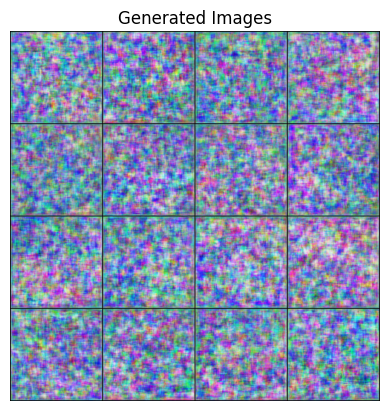

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image, UnidentifiedImageError
import os
from torchvision import transforms

# Generator Model
class Generator(nn.Module):
    def __init__(self, latent_dim=400, img_channels=3, img_size=64):
        super(Generator, self).__init__()
        
        self.init_size = img_size // 4  # Output size after upscaling (from 4x4)
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 128 * self.init_size ** 2),  # Latent dimension 400 -> 128 channels
            nn.BatchNorm1d(128 * self.init_size ** 2),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.conv_blocks = nn.Sequential(
            nn.Upsample(scale_factor=2),  # Upscale from 4x4 -> 8x8
            nn.Conv2d(128, 128, 3, stride=1, padding=1),  # Conv1: 128 channels
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Upsample(scale_factor=2),  # Upscale from 8x8 -> 16x16
            nn.Conv2d(128, 128, 3, stride=1, padding=1),  # Conv2: 128 channels
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Upsample(scale_factor=2),  # Upscale from 16x16 -> 32x32
            nn.Conv2d(128, 128, 3, stride=1, padding=1),  # Conv3: 128 channels
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Upsample(scale_factor=2),  # Upscale from 32x32 -> 64x64
            nn.Conv2d(128, 64, 3, stride=1, padding=1),  # Conv4: 64 channels
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, img_channels, 3, stride=1, padding=1),  # Output: 3 channels (RGB)
            nn.Tanh()  # Output range [-1, 1]
        )

    def forward(self, z):
        out = self.fc(z)
        out = out.view(out.size(0), 128, self.init_size, self.init_size)  # Reshape into 128x4x4
        img = self.conv_blocks(out)  # Pass through conv layers
        return img

# Function to load the model with matching architecture
def load_model_from_checkpoint(model, checkpoint_path, device):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model_dict = model.state_dict()
    
    # Filter out the weights that match by name and shape
    checkpoint_dict = checkpoint['generator_state_dict']
    
    filtered_checkpoint_dict = {k: v for k, v in checkpoint_dict.items() if k in model_dict and v.size() == model_dict[k].size()}
    model_dict.update(filtered_checkpoint_dict)  # Update model state dict with compatible layers
    model.load_state_dict(model_dict)  # Load filtered weights into model
    
    return model

# Dataset class
class YelpPhotoDataset(Dataset):
    def __init__(self, photos_folder, image_size=64, max_samples=None):
        self.photos_folder = photos_folder
        self.image_size = image_size
        self.image_files = [f for f in os.listdir(photos_folder) if f.endswith('.jpg')]
        if max_samples:
            self.image_files = self.image_files[:max_samples]

    def __getitem__(self, idx):
        img_path = os.path.join(self.photos_folder, self.image_files[idx])
        try:
            image = Image.open(img_path).convert('RGB')
            image = image.resize((self.image_size, self.image_size))
            image = transforms.ToTensor()(image)
            return image
        except (UnidentifiedImageError, IOError) as e:
            print(f"Error loading image {img_path}: {e}")
            return None

    def __len__(self):
        return len(self.image_files)

# Initialize dataset, dataloader
photos_folder = 'C:/Users/singh/Downloads/yelp_dataset/photos'
dataset = YelpPhotoDataset(photos_folder, image_size=64, max_samples=500)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=0)

# Set up device and load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator(latent_dim=400, img_channels=3, img_size=64).to(device)

# Load the model with the checkpoint
checkpoint_path = 'wgan_model_v1.pth'
generator = load_model_from_checkpoint(generator, checkpoint_path, device)

# Verify the model architecture
print(generator)

# Generate images for testing
fixed_z = torch.randn(16, 400, device=device)  # Latent vector (size 400)

# Generate and display images
with torch.no_grad():
    gen_imgs = generator(fixed_z).cpu()
    gen_imgs = gen_imgs * 0.5 + 0.5  # Rescale to [0, 1]
    grid = torchvision.utils.make_grid(gen_imgs, nrow=4, normalize=True)
    plt.imshow(grid.permute(1, 2, 0))
    plt.title("Generated Images")
    plt.axis('off')
    plt.show()
